In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import time
from IPython.display import display, clear_output

from helpers import (find_seam, 
                     rm_seam, 
                     duplicate_seam,
                     calc_energy_e1,
                     calc_cme,
                     gen_diag_iter_inds
                     )

%matplotlib inline

(64, 88, 3)
(127, 175, 3)
(254, 350, 3)


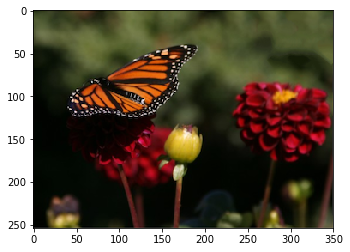

In [72]:
def imread(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def imwrite(path, img):
    cv2.imwrite(path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR)) 

fig7ss = imread("./images/fig7_ss.png")
fig7s = imread("./images/fig7_s.png")
fig7 = imread("./images/fig7.png")
plt.imshow(fig7)
print(fig7ss.shape)
print(fig7s.shape)
print(fig7.shape)

In [20]:
def retarget(image):
    h, w, _ = image.shape
    
    images = {(0, 0): image.copy()} # (r,c): image
    direction = np.zeros((h-1, w-1), dtype=bool) # True-vertical, False-horizontal
    T = np.zeros((h-1, w-1), dtype=np.uint32)
    
    i=0
    total = (h-1)*(w-1)
    ts = time.time()
    
    for r, c in gen_diag_iter_inds(h-1, w-1):
        i += 1
        clear_output(wait=True)
        display('{}/{} in {}s'.format(i, total, time.time()-ts))
        
        if (r, c) == (0, 0):
            continue
        
        if r == 0:
            # top edge
            
            # vertical removal
            img_v = images[(r, c-1)]
            seam_v, e_v = find_seam(img_v, direction='vertical', return_enrg=True)
            images[(r, c)] = rm_seam(img_v, seam_v, direction='vertical')
            T[r, c] = T[r, c-1] + e_v
            direction[r, c] = True
        
        elif c == 0:
            # left edge
            
            # horizontal removal
            img_h = images[(r-1, c)]
            seam_h, e_h = find_seam(img_h, direction='horizontal', return_enrg=True)
            images[(r, c)] = rm_seam(img_h, seam_h, direction='horizontal')
            T[r, c] = T[r-1, c] + e_h
            direction[r, c] = False
            
        else:
            # middle
            
            # horizontal removal seam
            img_h = images[(r-1, c)]
            seam_h, e_h = find_seam(img_h, direction='horizontal', return_enrg=True)
            
            # vertical removal seam
            img_v = images[(r, c-1)]
            seam_v, e_v = find_seam(img_v, direction='vertical', return_enrg=True)
            
            if (T[r-1, c] + e_h) < (T[r, c-1] + e_v):
                # removing horizontal seam is more efficient
                images[(r, c)] = rm_seam(img_h, seam_h, direction='horizontal')
                T[r, c] = T[r-1, c] + e_h
                direction[r, c] = False
            else:
                # removing vertical seam is more efficient
                images[(r, c)] = rm_seam(img_v, seam_v, direction='vertical')
                T[r, c] = T[r, c-1] + e_v
                direction[r, c] = True
                
    return T, direction, images
        


In [59]:
def color_T(T):
    T_norm = T.copy()
    T_norm = T_norm.astype(np.float32)
#     cv2.normalize(T, T_norm, 0, 255, cv2.NORM_MINMAX)
    T_norm *= (255.0/T_norm.max())
    T_norm = T_norm.astype(np.uint8)
    T_colored = cv2.applyColorMap(T_norm, cv2.COLORMAP_JET)
    T_colored = cv2.cvtColor(T_colored, cv2.COLOR_BGR2RGB)
    return T_colored

In [66]:
def resize_optimally(images, direction, T, py=.5, px=.7):
    h, w, _ = images[(0,0)].shape
    new_h = int(h * py)
    new_w = int(w * px)
    
    r = h - new_h
    c = w - new_w
    
    opt_path = color_T(T)
    i=r
    j=c
    while not (i==0 and j==0):
        opt_path[i, j] = [255,255,255]
        if direction[i, j]:
            # next is vertical
            j -= 1
        else:
            # next is horizontal
            i -= 1
    
    return images[(r, c)], opt_path

In [22]:
T_ss, direction_ss, images_ss = retarget(fig7ss)

'5481/5481 in 65.3731060028s'

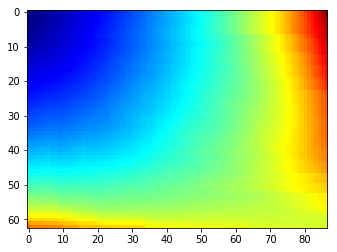

In [60]:
plt.imshow(color_T(T_ss))

In [57]:
T_s, direction_s, images_s = retarget(fig7s)

'21924/21924 in 1084.53530002s'

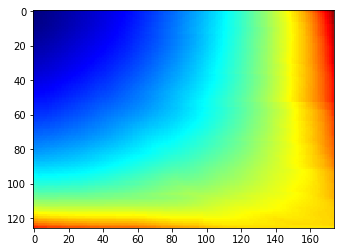

In [58]:
plt.imshow(color_T(T_s))

In [67]:
img, opt_path = resize_optimally(images_s, direction_s, T_s)

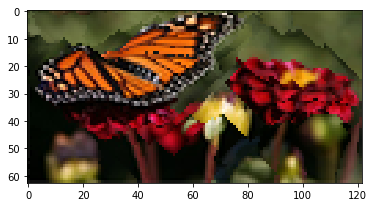

In [70]:
imwrite('test_img/fig7_s_img.png', img)
plt.imshow(img)

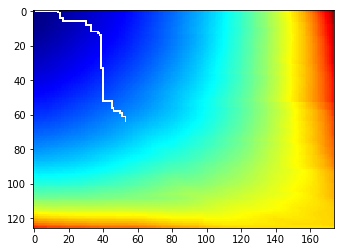

In [71]:
imwrite('test_img/fig7_s_path.png', opt_path)
plt.imshow(opt_path)

# Full

In [ ]:
T, direction, images = retarget(fig7)

'2082/88297 in 887.402310133s'

In [ ]:
plt.imshow(color_T(T))

In [ ]:
img, opt_path = resize_optimally(images, direction, T)

In [ ]:
imwrite('test_img/fig7_img.png', img)
plt.imshow(img)

In [ ]:
imwrite('test_img/fig7_path.png', opt_path)
plt.imshow(opt_path)